## Loading the data

In [74]:
import pandas as pd
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
import tensorflow as tf
from sklearn import metrics as mt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from sklearn import metrics as mt
from tensorflow import keras

In [68]:

df_original = pd.read_csv('../telecom_users.csv')
df_original.columns
#THERE IS NO CHANGING ORIGINAL
df_original = df_original[df_original.TotalCharges.str.strip() != ""]
y_df_orginal = df_original['Churn']
df_original.drop(['Unnamed: 0', 'customerID','Churn'],axis=1, inplace=True)
#df_original[df_original.SeniorCitizen] = np.where(df_original.SeniorCitizen == 0, "no", "yes")
df_original["SeniorCitizen"] = df_original["SeniorCitizen"].apply(
    lambda x: "yes" if x == 0 else " no")

In [69]:
#THERE IS NO CHANGING ORIGINAL
X_train_df, X_test_df, y_train_df, y_test_df = \
    train_test_split(df_original, y_df_orginal, test_size=0.2)

X_train_df = deepcopy(X_train_df)
X_train_df.dropna(inplace=True)
X_train_df.reset_index()

X_test_df = deepcopy(X_test_df)
X_test_df.dropna(inplace=True)
X_test_df.reset_index()

,index,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,3544,Female,yes,Yes,Yes,68,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,No,Two year,Yes,Credit card (automatic),84.40,5746.75
1,2396,Male,yes,Yes,Yes,13,Yes,No,Fiber optic,Yes,No,No,No,No,Yes,Month-to-month,No,Electronic check,84.05,1095.3
2,3105,Male,yes,Yes,No,61,Yes,Yes,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Mailed check,69.90,4226.7
3,1698,Female,no,Yes,No,5,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,70.05,302.6
4,4353,Female,yes,No,No,17,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.40,358.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,108,Female,yes,No,No,58,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,No,One year,Yes,Credit card (automatic),71.10,4299.2
1192,4638,Male,yes,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.30,70.3
1193,1685,Male,yes,Yes,No,42,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),25.10,1097.15
1194,4829,Male,yes,No,Yes,15,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Electronic check,91.00,1430.05


#### Turn all catagorical data into intergers

In [98]:
df_processed = deepcopy(df_original)
encoders = dict() 
categorical_headers = ['gender','SeniorCitizen','Partner','Dependents',
                       'PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                      'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract',
                      'PaperlessBilling','PaymentMethod']


numeric_headers = ["tenure", "MonthlyCharges", "TotalCharges"]


for col in categorical_headers:
    # integer encoded variables
    encoders[col] = LabelEncoder() # save the encoder
    X_train_df[col+'_int'] = encoders[col].fit_transform(X_train_df[col])
    X_test_df[col+'_int'] = encoders[col].transform(X_test_df[col])
    
for col in numeric_headers:
    X_train_df[col] = X_train_df[col].astype(np.float)
    X_test_df[col] = X_test_df[col].astype(np.float)
    
    ss = StandardScaler()
    X_train_df[col] = ss.fit_transform(X_train_df[col].values.reshape(-1, 1))
    X_test_df[col] = ss.transform(X_test_df[col].values.reshape(-1, 1))

### Identify Groups to Combine

* We think it will be easier for a cutomer to continue service if it is done automatically, therefore we would like to combine **Paperless billing, payment method, and contract.**
* We would also like to group the demographic data, **SeniorCitizen, Partner, Dependents, Gender**
* We want to group what services they opted into, **StreamingTv, StreamingMovies**
* Lastly we want to group **PhoneService, MultipleLines and InternetService**

TODO: Come back to the left over categories

### Create Cross Columns

In [99]:
cross_columns = [['Contract','PaperlessBilling','PaymentMethod'],
                 ['SeniorCitizen','Partner','Dependents'],
                 ['StreamingTV','StreamingMovies'],
                 ['PhoneService','MultipleLines','InternetService']]

cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = X_train_df[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test_df[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    X_train_df[cross_col_name] = enc.transform(X_crossed_train)
    X_test_df[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    

In [105]:
X_train_df[cross_col_df_names].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4780 entries, 1731 to 5173
Data columns (total 4 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Contract_PaperlessBilling_PaymentMethod     4780 non-null   int32
 1   SeniorCitizen_Partner_Dependents            4780 non-null   int32
 2   StreamingTV_StreamingMovies                 4780 non-null   int32
 3   PhoneService_MultipleLines_InternetService  4780 non-null   int32
dtypes: int32(4)
memory usage: 112.0 KB


In [130]:
y_train_df.replace(to_replace=['Yes','No'], value=[0,1], inplace=True)

In [131]:
y_train_df

1731    1
2449    0
674     0
205     1
767     1
       ..
4824    1
4710    0
5157    1
4753    1
5173    1
Name: Churn, Length: 4780, dtype: int64

In [132]:
# get crossed columns
X_train_crossed = X_train_df[cross_col_df_names].to_numpy()
X_test_crossed = X_test_df[cross_col_df_names].to_numpy()

crossed_outputs = [] # this is where we will keep track of output of each branch

input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='categorical')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train_df[col].max(),X_test_df[col].max())+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='concat_1')
wide_branch = Dense(units=1,activation='sigmoid', name='combined')(wide_branch)


model = Model(inputs=input_crossed, outputs=wide_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_train_crossed,
        y_train_df.to_numpy(), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
150/150 [==============================] - 0s 473us/step - loss: 0.2383 - accuracy: 0.7186
Epoch 2/10
150/150 [==============================] - 0s 480us/step - loss: 0.2216 - accuracy: 0.7416
Epoch 3/10
150/150 [==============================] - 0s 467us/step - loss: 0.2106 - accuracy: 0.7416
Epoch 4/10
150/150 [==============================] - 0s 473us/step - loss: 0.2031 - accuracy: 0.7416
Epoch 5/10
150/150 [==============================] - 0s 500us/step - loss: 0.1978 - accuracy: 0.7416
Epoch 6/10
150/150 [==============================] - 0s 500us/step - loss: 0.1940 - accuracy: 0.7416
Epoch 7/10
150/150 [==============================] - 0s 480us/step - loss: 0.1910 - accuracy: 0.7416
Epoch 8/10
150/150 [==============================] - 0s 520us/step - loss: 0.1887 - accuracy: 0.7416
Epoch 9/10
150/150 [==============================] - 0s 560us/step - loss: 0.1868 - accuracy: 0.7416
Epoch 10/10
150/150 [==============================] - 0s 533us/step - loss: 0.185

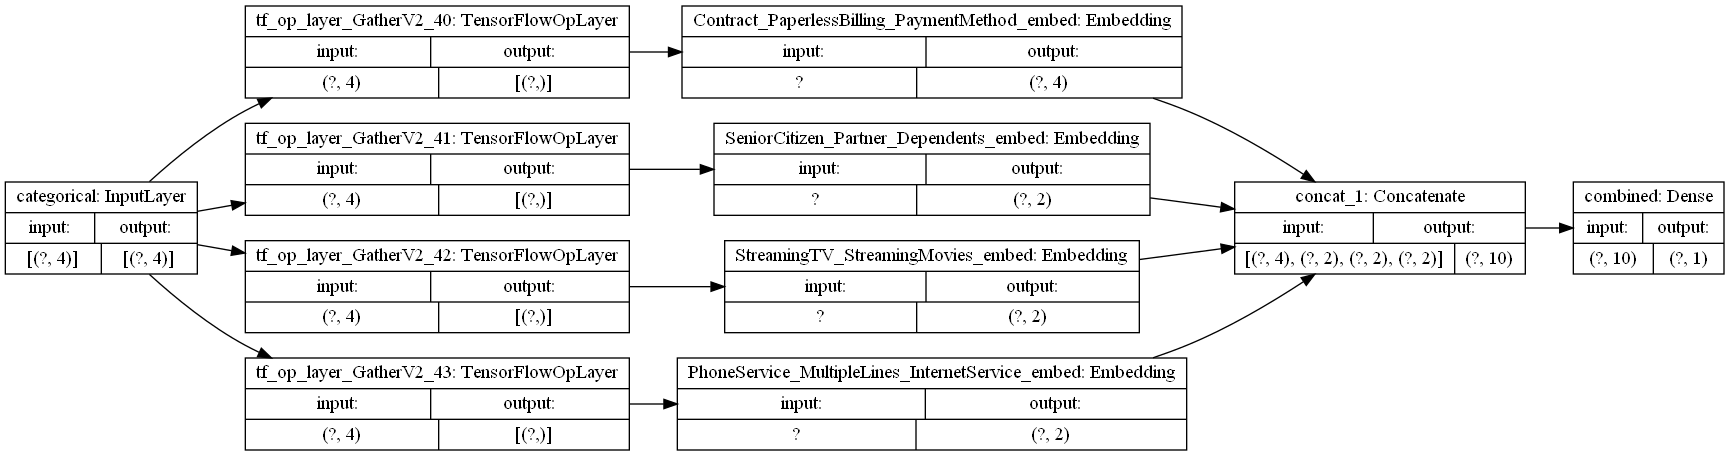

In [110]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [84]:
%%time

model.fit(X_train_df, y_train, epochs=10, batch_size=50, verbose=1)

yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

NameError: name 'X_train' is not defined